In [1]:
###################
# from U-Net
###################
import os
import sys
import glob
import random
import datetime
import warnings


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from itertools import chain
import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


######################
#from mask-RCNN
######################
import cv2

# to ignore warnings
warnings.filterwarnings('ignore')
#to plot things inline in jupyter
%matplotlib inline

Using TensorFlow backend.


# Loading u-net

In [3]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
model.summary()

### testing an image with u-net

# Loading mask-RCNN

original had an inference_config in <br>model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR) <br> but i changed it to hs_config (before the weights were for resNet101, but resnet50 was being loaded). 
Also, since the batch size for resNet101 training was 2, here we need to suply to images for prediction.

In [2]:
import utils as utl
from hs_config import hs_config
from bowl_dataset import BowlDataset
import hsModel as modellib
import functions as f


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        512
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               256
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           hsConfig
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAININ

In [4]:
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [5]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=hs_config,
                          model_dir=MODEL_DIR)
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
rpn_class (Concatenate)         (None, None, 2)      0           rpn_model[1][1]                  
                                                                 rpn_model[2][1]                  
                                                                 rpn_model[3][1]                  
                                                                 rpn_model[4][1]                  
                                                                 rpn_model[5][1]                  
__________________________________________________________________________________________________
rpn_bbox (Concatenate)          (None, None, 4)      0           rpn_model[1][2]                  
                                                                 rpn_model[2][2]                  
                                                                 rpn_model[3][2]                  
          

In [6]:
model_path = os.path.join(MODEL_DIR, 'hsconfig20180316T2211/mask_rcnn_hsconfig_0009.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/hooman67/Cell_Nuclei_Segmentation/kaggle-ds-bowl-2018-baseline/logs/hsconfig20180316T2211/mask_rcnn_hsconfig_0009.h5


### testing an image with mask-RCNN

In [7]:
# load training set
training_set = BowlDataset()
training_set.load_bowl('stage1_train')
training_set.prepare()

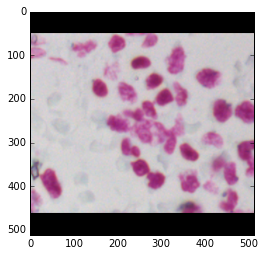

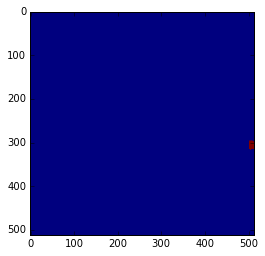

In [9]:
# load ground truth for an image
gt_image, gt_image_meta, gt_class_ids, gt_bbox, gt_masks = modellib.load_image_gt(training_set, hs_config, 50)
plt.figure()
plt.imshow(gt_image)
plt.figure()
plt.imshow(gt_masks[:,:,13])

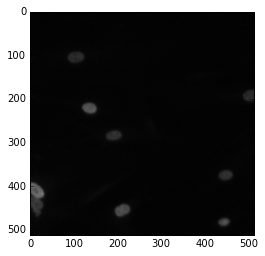

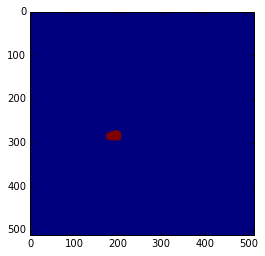

In [13]:
# load ground truth for an image
gt_image2, gt_image_meta2, gt_class_ids2, gt_bbox2, gt_masks2 = modellib.load_image_gt(training_set, hs_config, 51)
plt.figure()
plt.imshow(gt_image2)
plt.figure()
plt.imshow(gt_masks2[:,:,1])

In [22]:
# hs thsi performs predictions and stores the results in r.
results = model.detect([gt_image, gt_image2], verbose=0)

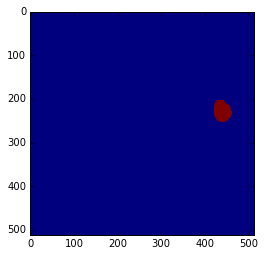

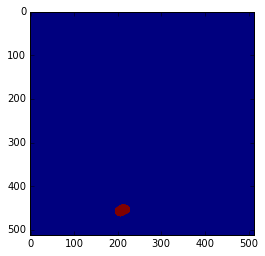

In [23]:
r1 = results[0]
r2 = results[1]

plt.figure()
plt.imshow(r1['masks'][:,:,1])

plt.figure()
plt.imshow(r2['masks'][:,:,1])

In [19]:
# For image1 we could only segment 14 out of 28 masks in GT
# gt_image.shape     == (512, 512, 3)
# gt_masks.shape     == (512, 512, 28)
# gt_bbox.shape      == (28, 4)
# gt_class_ids.shape == (28,)

# r['masks'].shape     == (512, 512, 14)
# r['rois'].shape      == (14, 4)
# r['class_ids'].shape == (14,)
# r['scores'].shape    == (14,)

print(r['masks'].shape)
print(gt_masks.shape)
print(r['rois'].shape )
print(gt_bbox.shape)
print(r['class_ids'].shape)
print(gt_class_ids.shape)
print(r['scores'].shape)
print(gt_image.shape)

(512, 512, 41)
(512, 512, 42)
(41, 4)
(42, 4)
(41,)
(42,)
(41,)
(512, 512, 3)


# Reinforcement Learning

### From mask_RCNN

In [24]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [25]:
molded_images, image_metas, windows = model.mold_inputs([gt_image, gt_image2])
detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, \
            rois, rpn_class, rpn_bbox =\
            model.keras_model.predict([molded_images, image_metas], verbose=0)

In [26]:
print(detections.shape)   # (2, 512, 6)
print(mrcnn_class.shape)  # (2, 1000, 2)
print(mrcnn_bbox.shape)   # (2, 1000, 2, 4)
print(mrcnn_mask.shape)   # (2, 512, 28, 28, 2)
print(rois.shape)         # (2, 1000, 4)
print(rpn_class.shape)    # (2, 65472, 2)
print(rpn_bbox.shape)     # (2, 65472, 4)

(2, 512, 6)
(2, 1000, 2)
(2, 1000, 2, 4)
(2, 512, 28, 28, 2)
(2, 1000, 4)
(2, 65472, 2)
(2, 65472, 4)


In [30]:
# Process detections
results = []
for i, image in enumerate([gt_image, gt_image2]):
    final_rois, final_class_ids, final_scores, final_masks =\
        model.unmold_detections(detections[i], mrcnn_mask[i],
                               image.shape, windows[i])
    results.append({
        "rois": final_rois,
        "class_ids": final_class_ids,
        "scores": final_scores,
        "masks": final_masks,
    })

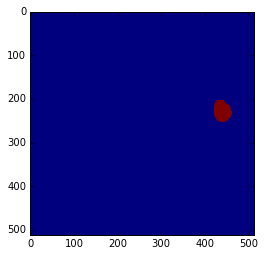

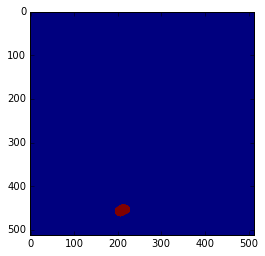

In [31]:
r1 = results[0]
r2 = results[1]

plt.figure()
plt.imshow(r1['masks'][:,:,1])

plt.figure()
plt.imshow(r2['masks'][:,:,1])

### From U-Net

In [ ]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
model.summary()

In [ ]:
xx = model.get_layer('conv2d_18').output
new_baseMod = Model(model.input, xx)
new_baseMod.summary()

In [ ]:
yy = model.get_layer('conv2d_19') (xx)
new_model = Model(model.input, yy)
new_model.summary()